In [2]:
!pip install google-search-results
!pip install opencv-python
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32009 sha256=461c35d692e8b150148ff679a70bde73cc09b6872c30c07580198a9574bc91da
  Stored in directory: /root/.cache/pip/wheels/6e/42/3e/aeb691b02cb7175ec70e2da04b5658d4739d2b41e5f73cd06f
Successfully built google-search-results


In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import requests
from serpapi import GoogleSearch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

In [4]:
# Function to download Google images
def download_google_image(product_name, save_path="product_images"):
    params = {
        "q": product_name,
        "tbm": "isch",  # Image search
        "num": 1,  # Number of images to download
        "api_key": "fb1d0a53876a03be5287c81e5635898f8c443af8b455f5959bad1e0b17e7f9ee"
    }

    # Perform the search
    search = GoogleSearch(params)
    results = search.get_dict()
    images = results.get("images_results", [])

    # Download the first image
    if images:
        img_url = images[0]['original']
        img_data = requests.get(img_url).content

        # Create the save directory if it doesn't exist
        os.makedirs(save_path, exist_ok=True)

        # Save the image
        file_path = os.path.join(save_path, f"{product_name}.jpg")
        with open(file_path, 'wb') as handler:
            handler.write(img_data)

        print(f"Downloaded: {file_path}")
        return file_path
    else:
        print(f"No images found for {product_name}.")
        return None

# Example: Download an apple image
download_google_image("apple")

Downloaded: product_images/apple.jpg


'product_images/apple.jpg'

In [6]:
# Load item labels
data = pd.read_csv('/content/sample_data/items.csv')
print(data.head())

# Download images for each product in the dataset
image_folder = "product_images"
for product_name in data['item_name']:
    download_google_image(product_name, save_path=image_folder)

# Preprocess images
def load_images(image_folder, labels_df):
    images = []
    labels = []

    for img_name in labels_df['item_name']:  # Use 'item_name' to match downloaded images
        img_path = os.path.join(image_folder, f"{img_name}.jpg")
        print(f"Loading image: {img_path}")  # Debug: Print the image path

        # Check if the file exists
        if not os.path.exists(img_path):
            print(f"Error: File not found - {img_path}")
            continue

        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (64, 64))
            images.append(img)
            label = labels_df[labels_df['item_name'] == img_name]['item_name'].values[0]
            labels.append(label)
        else:
            print(f"Warning: Unable to load image {img_path}")

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(image_folder, data)

# Check if images were loaded
if len(images) == 0:
    raise ValueError("No images were loaded. Check the image folder path and filenames.")

# Normalize images
images = images / 255.0

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Check the shape of X_train and y_train
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Fix X_train shape if necessary
if X_train.ndim == 3:
    X_train = np.expand_dims(X_train, axis=-1)  # Add a channel dimension if missing
elif X_train.shape[-1] != 3:
    raise ValueError(f"Expected 3 channels (RGB), but got {X_train.shape[-1]} channels.")

# Fix y_train shape if necessary
if y_train.ndim != 1:
    y_train = np.squeeze(y_train)

   image_name item_name category  price  barcode
0   apple.jpg     Apple    Fruit   0.99   100001
1  banana.jpg    Banana    Fruit   0.59   100002
2   bread.jpg     Bread   Bakery   2.49   100003
3    milk.jpg      Milk    Dairy   3.29   100004
4    eggs.jpg      Eggs    Dairy   2.99   100005
Downloaded: product_images/Apple.jpg
Downloaded: product_images/Banana.jpg
Downloaded: product_images/Bread.jpg
Downloaded: product_images/Milk.jpg
Downloaded: product_images/Eggs.jpg
Downloaded: product_images/Cheese.jpg
Downloaded: product_images/Tomato.jpg
Downloaded: product_images/Potato.jpg
Downloaded: product_images/Carrot.jpg
Downloaded: product_images/Orange.jpg
Downloaded: product_images/Chicken.jpg
Downloaded: product_images/Beef.jpg
Downloaded: product_images/Rice.jpg
Downloaded: product_images/Pasta.jpg
Downloaded: product_images/Yogurt.jpg
Downloaded: product_images/Butter.jpg
Downloaded: product_images/Fish.jpg
Downloaded: product_images/Lettuce.jpg
Downloaded: product_images/Grapes

In [7]:
# Encode labels to zero-indexed integers
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Check the unique labels after encoding
print(f"Unique labels in y_train: {np.unique(labels_encoded)}")

Unique labels in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [8]:
# Build a CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with 14 units
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
from tensorflow.keras.layers import Input

# Build a CNN model
model = Sequential([
    Input(shape=(64, 64, 3)),  # Explicitly define the input shape
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with 14 units
])

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0714 - loss: 2.9049 - val_accuracy: 0.0000e+00 - val_loss: 4.4349
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.0000e+00 - loss: 3.6765 - val_accuracy: 0.0000e+00 - val_loss: 4.6279
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.0714 - loss: 3.0123 - val_accuracy: 0.0000e+00 - val_loss: 4.1481
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.0714 - loss: 2.4440 - val_accuracy: 0.0000e+00 - val_loss: 3.8461
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2143 - loss: 2.4483 - val_accuracy: 0.0000e+00 - val_loss: 3.6498
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4286 - loss: 2.2313 - val_accuracy: 0.0000e+00 - val_loss: 3.6001
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5000 - loss: 1.9908 - val_accuracy: 0.0000e+00 - val_loss: 3.6550
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4286 - loss: 2.1026 - val

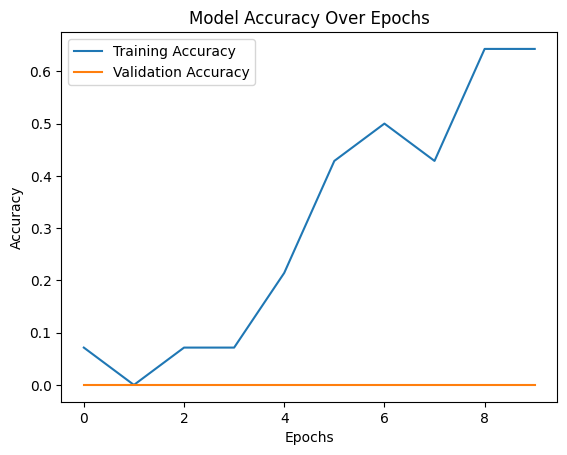

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Plot training results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

Unique labels in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - loss: 2.8601 - val_accuracy: 0.0000e+00 - val_loss: 4.3118
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.0714 - loss: 3.0247 - val_accuracy: 0.0000e+00 - val_loss: 4.0638
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.0000e+00 - loss: 3.0027 - val_accuracy: 0.0000e+00 - val_loss: 3.9764
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1429 - loss: 2.7482 - val_accuracy: 0.0000e+00 - val_loss: 3.7098
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.3571 - loss: 2.3725 - val_accuracy: 0.0000e+00 - val_loss: 3.6252
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5714 - loss: 2.0622 - val_accuracy: 0.0000e+00 - val_loss: 3.7317
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.3571 - loss: 2.1179 - val_accuracy: 0.0000e+00 - val_loss: 3.8890
Epo

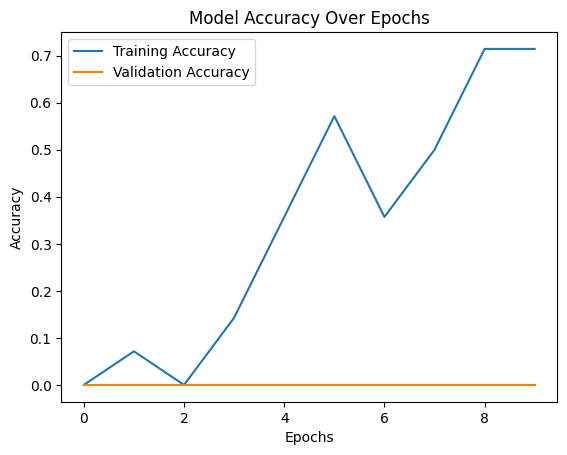

In [11]:
# Encode labels to zero-indexed integers
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Check the unique labels after encoding
print(f"Unique labels in y_train: {np.unique(labels_encoded)}")

# Build a CNN model
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(64, 64, 3)),  # Explicitly define the input shape
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with 14 units
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Plot training results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0000e+00 - loss: 4.6413
Test Loss: 4.641341209411621
Test Accuracy: 0.0


In [13]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the predicted and actual labels
print("Predicted Labels:", y_pred_classes)
print("Actual Labels:", y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Predicted Labels: [16  7 11 11]
Actual Labels: [0 1 4 5]


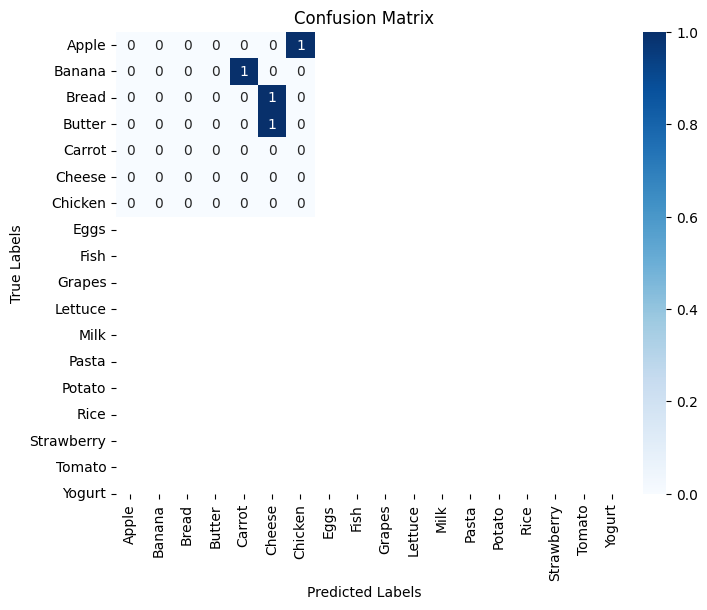

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Save the model in the native Keras format
model.save('product_classification_model.keras')
print("Model saved as 'product_classification_model.keras'")

Model saved as 'product_classification_model.keras'


In [16]:

def classify_image(image_path, model, encoder):
    # Check if the image file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file '{image_path}' does not exist.")

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Unable to load the image from '{image_path}'. Check the file path and format.")

    # Resize and preprocess the image
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)

    # Decode the predicted class
    predicted_label = encoder.inverse_transform(predicted_class)
    return predicted_label[0]

In [24]:
print("Predicted class indices:", y_pred_classes)


Predicted class indices: [16  7 11 11]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Unique classes in y_test: [0 1 4 5]
Unique classes in y_pred_classes: [ 7 11 16]
Encoder classes: ['Apple' 'Banana' 'Carrot' 'Cheese' 'Class10' 'Class11' 'Class12'
 'Class13' 'Class14' 'Class15' 'Class16' 'Class17' 'Class18' 'Class5'
 'Class6' 'Class7' 'Class8' 'Class9']


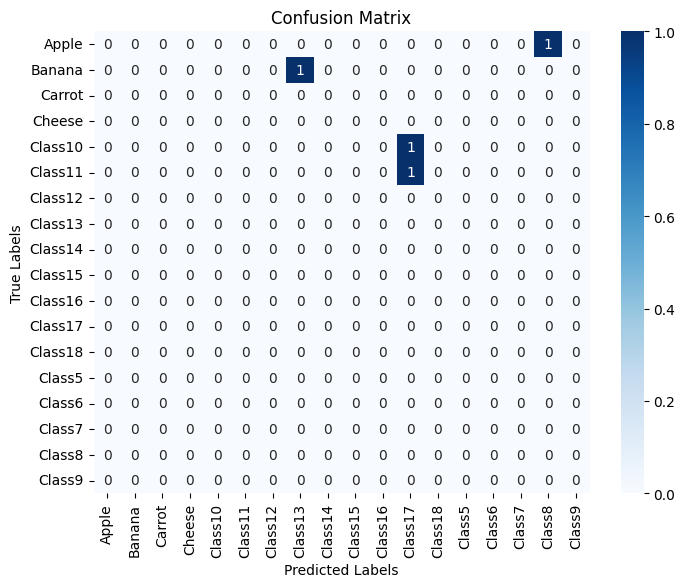

ValueError: Number of classes, 7, does not match size of target_names, 18. Try specifying the labels parameter

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Expand the encoder to include all possible classes predicted by the model
all_classes = ['Apple', 'Banana', 'Carrot', 'Cheese', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10',
               'Class11', 'Class12', 'Class13', 'Class14', 'Class15', 'Class16', 'Class17', 'Class18']  # Add all 18 classes
encoder = LabelEncoder()
encoder.fit(all_classes)  # Fit the encoder to the complete list of classes

# Generate predictions on the test set
y_pred = model.predict(X_test)  # Ensure model outputs probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Ensure y_test is encoded using the same encoder
y_test_encoded = y_test  # Use actual raw labels or already encoded labels

# Print unique classes for debugging
print("Unique classes in y_test:", np.unique(y_test_encoded))
print("Unique classes in y_pred_classes:", np.unique(y_pred_classes))
print("Encoder classes:", encoder.classes_)

# Convert predicted and actual labels back to original class names
y_pred_labels = encoder.inverse_transform(y_pred_classes)
y_test_labels = encoder.inverse_transform(y_test_encoded)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate additional performance metrics: Precision, Recall, F1-Score
report = classification_report(y_test_labels, y_pred_labels, target_names=encoder.classes_)
print("Classification Report:\n", report)
